Still to do :
- Matching the beer between both datasets to get enough ratings for each beer (only treating BeerAdvocate in the second part of this preliminary analysis)
- Keep diving into WHAT makes a beer controversial (such as the attribute)
- Try to aggregate somehow the attribute and see WHICH beers are controversial (maybe by style or abv or...)
- ...


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np


In [2]:
# Later we will important the cleaned dataset
# BA for Beer Advocate datasets
# RB for Rate Beer datasets
# need to convert the review and rating txt as csv

# Importation of dataset
beers_BA_df = pd.read_csv('../Dataset/BeerAdvocate/beers.csv')
beers_RB_df = pd.read_csv('../Dataset/RateBeer/beers.csv')
users_BA_df = pd.read_csv('../Dataset/BeerAdvocate/users.csv')
users_RB_df = pd.read_csv('../Dataset/RateBeer/users.csv')




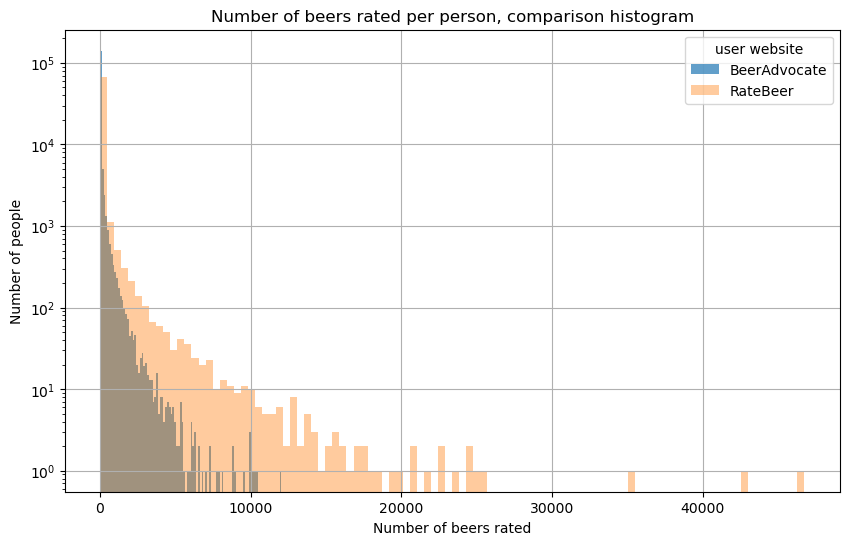

In [3]:
# Plotting number of ratings made per user in an histogram
plt.figure(figsize=(10, 6))

users_BA_df['nbr_ratings'].hist(bins=100, log=True, alpha=0.7, label='BeerAdvocate')
users_RB_df['nbr_ratings'].hist(bins=100,log=True, alpha=0.4, label='RateBeer')

plt.xlabel("Number of beers rated")
plt.ylabel("Number of people")
plt.legend(title='user website')
plt.title('Number of beers rated per person, comparison histogram')
plt.show()

RateBeer has only about 20-30 users with more than 12'000 ratings
BeerAdvocate has only abouth 20-30 users above 5'000

Now is time to define class on users related to how many ratings they did.
- Novice are users with only a few ratings, let's say 1-20.
- Enthusiasts are users with moderate number of ratings, let's say 21-100
- Connoisseur are users with high number of ratings, let's say 101+

It is important to note that this choice is arbitrary. It could me made differently or could be interactive for the reader of the story to label the users differently according to how many ratings he thinks is enough to be a connoisseur/enthusiasts/novice.

Another important things to take into account is that these classes do not represent users as novice or connoisseur about **beers**, but about **rating** on this particular website.

Let's classify now the users in the three mentioned categories.



In [4]:
def classify_user_rating_level(user_df, novice_level=20, enthusiasts_level=100):
    
    def __classify(nbr_ratings):
        if nbr_ratings <= novice_level:
            return 'novice'
        elif nbr_ratings <= enthusiasts_level:
            return 'enthusiast'
        else:
            return 'connoisseur'
        
    user_df['rating_user_level'] = user_df['nbr_ratings'].apply(__classify)

    return user_df
    

In [5]:
users_classified_BA = classify_user_rating_level(users_BA_df)
users_classified_RB = classify_user_rating_level(users_RB_df)
print("Number of people per class BA dataset", users_classified_BA['rating_user_level'].value_counts())
print("Number of people per class RB dataset", users_classified_RB['rating_user_level'].value_counts())

Number of people per class BA dataset rating_user_level
novice         119819
enthusiast      19498
connoisseur     14387
Name: count, dtype: int64
Number of people per class RB dataset rating_user_level
novice         57937
connoisseur     6390
enthusiast      5847
Name: count, dtype: int64


As we can see, if we want to do further analysis using the three classes of users, we will need to either rebalance the datasets, weight the analysis, or...

Furthermore, we could try to aggregate people who rated on both sites ?

In [6]:
users_classified_RB.sample(3)


,nbr_ratings,user_id,user_name,joined,location,rating_user_level
56304,1,94275,dgeidner,1.249985e+09,NaN,novice
36588,1,367706,Ahenobarbus,1.430302e+09,Poland,novice
45329,3,237320,Riesett6717,1.357470e+09,"United States, Maryland",novice


We can keep this for further analysis. Let's pass to naive first analysis of the controversiality of attributes

Let's try now to get a glimpse of the controversiality of a beer by looking at each attribute of beers and their ratings values.

In [7]:
# Importing ratings in csv (8 minutes)
ratings_RB_df = pd.read_csv('../Dataset/RateBeer/ratings.csv')
ratings_BA_df = pd.read_csv('../Dataset/BeerAdvocate/ratings.csv')

In [8]:
ratings_RB_df.sample()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
4025455,Flying Dog Brewhouse Rarities: Black Honey IPA,294719,Flying Dog Brewery,109,Black IPA,NaN,1413972000,Maxbier,289313,4,6,3,7,15,3.5,"On tap at Red (Clarksville, MD). Dark brown wi..."


In [9]:
ratings_BA_df.sample()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
7540650,Bourbon County Brand Stout,10672,Goose Island Beer Co.,1146,American Double / Imperial Stout,13.8,1321354800,tat2dhllblly,tat2dhllblly.447171,NaN,NaN,NaN,NaN,NaN,5.0,NaN,False


In [10]:
# Different interesting attributed of a beer.
# attributed contains rated basic attributes
# extended_attributes contain everything than could be rated by users of the website
# external_attributes contain the attributes of the beer itself, independant of the ratings

attributes = ['appearance', 'aroma', 'palate', 'taste']
extended_attributes = attributes + ['overall', 'rating', 'text']
external_attributes = ['style', 'abv']

In [11]:
# Taking a part of the dataset to try and treat it faster.
# Unused for the moment. May be useless
ratings_BA_df_tmp = ratings_BA_df.iloc[0:math.floor(len(ratings_BA_df)/5)]
print(len(ratings_BA_df))
print(len(ratings_BA_df_tmp))

8393032
1678606


To analyze the controversiality of a beer, we need many ratings. As a result, we must choose a threshold deciding how many ratings are necessary for a beer to be used in the analysis. This number is arbitrary and could be chosen by the reader.

In [12]:
# Filtering beers 
low_threshold_nb_ratings = 10
high_threshold_nb_ratings = 50

filtered_beers_BA = beers_BA_df[beers_BA_df['nbr_ratings'] >= low_threshold_nb_ratings] # Could maybe keep only name and ID ? For memory purposes ?
print("Pourcentage of beers remaining : {:.2f} %".format(100 * len(filtered_beers_BA) / len(beers_BA_df)))
filtered_ratings_BA = ratings_BA_df[ratings_BA_df['beer_id'].isin(filtered_beers_BA['beer_id'])] # 30 seconds
print("Pourcentage of ratings remaining : {:.2f} %".format(100 * len(filtered_ratings_BA) / len(ratings_BA_df)))


Pourcentage of beers remaining : 21.79 %
Pourcentage of ratings remaining : 93.94 %


In [13]:
# Grouping ratings for each beer and finding the variance for each attribute
grouped_ratings_BA = filtered_ratings_BA.groupby('beer_id')

variance_ratings_attributes_BA = grouped_ratings_BA[attributes].var()

variance_ratings_attributes_BA.head(5)

,appearance,aroma,palate,taste
beer_id,,,,
4,0.413889,0.344444,0.566667,0.691667
5,0.295799,0.326182,0.352413,0.372201
6,0.198003,0.278801,0.289798,0.277225
7,0.401458,0.465628,0.431587,0.508657
8,0.367960,0.414098,0.428843,0.486016


In [36]:
variance_ratings_attributes_BA.describe()

,appearance,aroma,palate,taste
count,60231.000000,60231.000000,60231.000000,60231.000000
mean,0.197245,0.215052,0.229368,0.247306
std,0.159013,0.178171,0.185018,0.212878
min,0.000000,0.000000,0.000000,0.000000
25%,0.105865,0.109835,0.116326,0.118519
50%,0.161020,0.172760,0.183333,0.191667
75%,0.241883,0.266476,0.286261,0.307643
max,6.125000,6.125000,6.125000,8.000000


As we can see, attributes variance have a similar mean and standard deviation. Yet we can still get a little initial ranking :
- Taste seems to have the highest mean variance and standard deviation of all attributes. It may contain more controversial ratings and more "outliers", having really high or low variance.
- It is followed by palate, aroma and finally appearance. 

Let's explore further and try to understand deeper this distribution.
Let's try violin plots first :

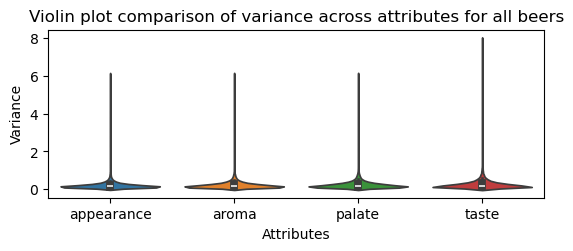

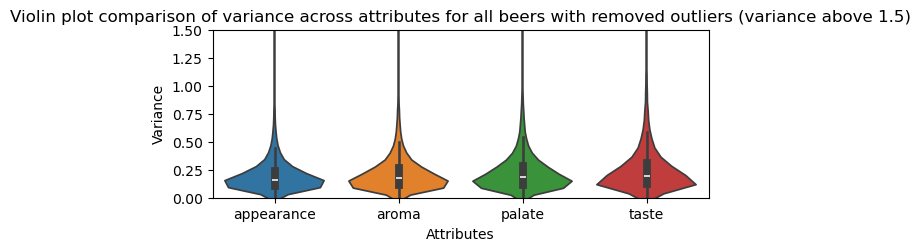

In [50]:
plt.subplot(2, 1, 1)
sns.violinplot(variance_ratings_attributes_BA[attributes])
plt.title("Violin plot comparison of variance across attributes for all beers")
plt.xlabel("Attributes")
plt.ylabel("Variance")
plt.show()

# Same graph with limited variance
plt.subplot(2, 1, 2)
sns.violinplot(variance_ratings_attributes_BA[attributes])
plt.title("Violin plot comparison of variance across attributes for all beers with removed outliers (variance above 1.5)")
plt.xlabel("Attributes")
plt.ylabel("Variance")
plt.ylim([0, 1.5])
plt.show()

As we can see, we have many outliers, making the distribution hard to read. Trying to remove really high value, the graph still does not provide many information. Let's try to use a boxplot

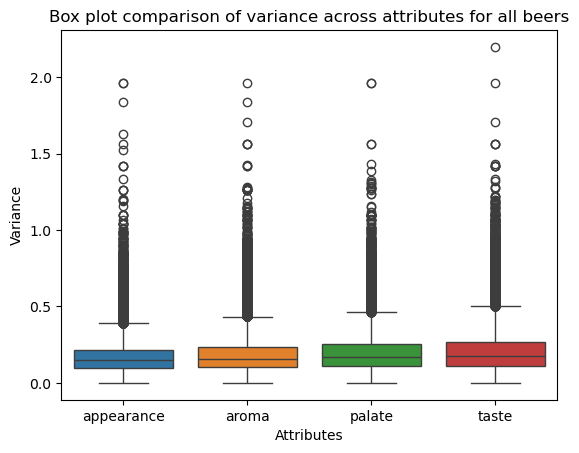

In [47]:
sns.boxplot(np.log1p(variance_ratings_attributes_BA[attributes]))
plt.title("Box plot comparison of variance across attributes for all beers")
plt.xlabel('Attributes')
plt.ylabel('Variance')
plt.show()

Again, even in log scale, the graph is dominated by the really high number of data close to the mean. But as we have many many "outliers", it is really hard to draw any information concerning controversiality of attributes here

Let's finally try to plot the distributions

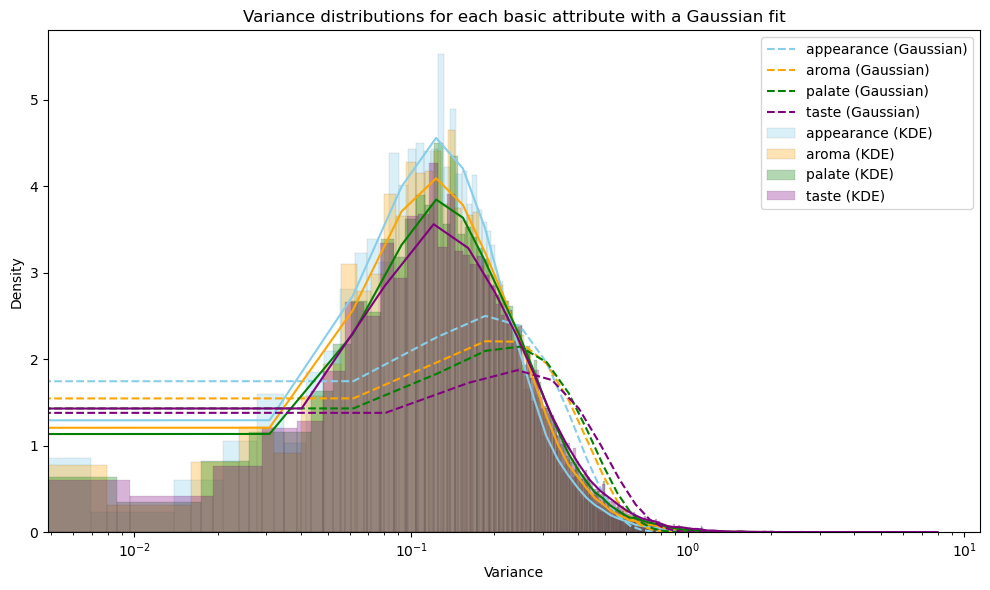

In [68]:
from scipy.stats import norm

plt.figure(figsize=(10, 6))
colors = ['skyblue', 'orange', 'green', 'purple']
for i, attribute in enumerate(attributes):
    #plt.hist(variance_ratings_attributes_BA[attribute], bins=10, log=(True, False))
    sns.histplot(variance_ratings_attributes_BA[attribute], kde=True, stat='density', color=colors[i], alpha=0.3, label=f"{attribute} (KDE)")

    mean = variance_ratings_attributes_BA[attribute].mean()
    std = variance_ratings_attributes_BA[attribute].std()
    
    # Generate x values for the Gaussian curve
    x = np.linspace(variance_ratings_attributes_BA[attribute].min(), 
                    variance_ratings_attributes_BA[attribute].max(), 100)
    
    # Plot the Gaussian curve as a dashed line
    plt.plot(x, norm.pdf(x, mean, std), color=colors[i], linestyle="--", label=f"{attribute} (Gaussian)")

plt.title('Variance distributions for each basic attribute with a Gaussian fit')
plt.xlabel("Variance")
plt.xscale("log")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()


Maybe we could do something like a big Gaussian with every variance. Then we find the value that are one std dev away from the mean and we select upper value to be controversial and lower value to be universal ????

The thing is for now we are looking for ALL beers with enough ratings what is the variance across the 4 different basic attributes.
We could :
- Look and groupby the type and abv of the beer. 
- "Group" the attributes and see if the beer is controversial
- Keep looking at WHAT makes it controversial


The 4 attributes are RATED by the user. While the abv and type of the beer are proper to the beer itself. We can either find which beers are controversial (style) or what makes it controversial......................